# Cohort analysis of profiles clinically annotated with the Molecular Oncology Almanac

This notebook features several analyses and figures that can be generated given a cohort of profiles that have been clinically annotated with the [Molecular Oncology Almanac](https://github.com/vanallenlab/moalmanac). The table of contents can be used to hyperlink to a particular section of the notebook, and all code should be run within the section to generate the intended output; however, code in the setup section should be run first.

<a href="anchor" id="table-of-contents"></a>
# Table of contents
Click on any blue hyperlink in the table of contents below to go to the relevent section of this Jupyter notebook.

[Setup](#setup), 
- [Import packages](#import-packages)
- [Load data](#load-data)
- [Configuration](#config)

[Questions](#questions),
- [How many patients were imported in the notebook](#how-many-patients-imported)
- [How many patients have genomic alterations?](#how-many-profiles-harbor-genomic-alterations)
- [How many alterations does each patient have, by feature type?](#what-is-the-distribution-of-genomic-alterations-per-sample)
- How many patients have at least one alteration associated with,
    - [therapeutic sensitivity?](#how-many-patients-have-at-least-one-alteration-associated-with-therapeutic-sensitivity)
    - [therapeutic resistance?](#how-many-patients-have-at-least-one-alteration-associated-with-therapeutic-resistance)
    - [disease prognosis?](#how-many-patients-have-at-least-one-alteration-associated-with-disease-prognosis)
- What percentage of patients have an association for therapeutic sensitivity,
    - [per evidence type?](#what-percentage-of-patients-have-an-association-for-therapeutic-sensitivity-per-evidence-type)
    - [per evidence type, cumulatively?](#what-percentage-of-patients-have-an-association-for-therapeutic-sensitivity-per-evidence-type-cumulatively)
- What are the most commonly observed
    - [alterations, by feature type?](#what-are-the-most-common-alterations-by-feature-type)
    - [clinically relevant alterations, by feature type?](#what-are-the-most-common-clinically-relevant-alterations-by-feature-type)
    - [biologically relevant alterations, by feature type?](#what-are-the-most-common-biologically-relevant-alterations-by-feature-type)
- Which therapies are most commonly highlighted,
    - [for therapeutic sensitivity?](#which-therapies-are-most-commonly-highlighted-for-therapeutic-sensitivity)
    - [for therapeutic resistance?](#which-therapies-are-most-commonly-highlighted-for-therapeutic-resistance)
- Which alteration and therapy pairs are most commonly highlighted,
    - [for therapeutic sensitivity?](#which-alteration-and-therapy-pairs-are-most-commonly-highlighted-for-therapeutic-sensitivity)
    - [for therapeutic resistance?](#which-alteration-and-therapy-pairs-are-most-commonly-highlighted-for-therapeutic-resistance)


[Figures](#figures),
- [Patients with clinically relevant alterations, by feature type](#patients-with-clinically-relevant-alterations-by-feature-type)
- Associations by evidence for,
    - [therapeutic sensitivity](#associations-by-evidence-for-therapeutic-sensitivity)
    - [therapeutic resistance](#associations-by-evidence-for-therapeutic-resistance)
    - [disease prognosis](#associations-by-evidence-for-disease-prognosis)
- Counts of patients by evidence with at least one alteration associated with,
    - [therapeutic sensitivity](#fraction-of-patients-by-evidence-sensitivity)
    - [therapeutic resistance](#fraction-of-patients-by-evidence-resistance)
    - [disease prognosis](#fraction-of-patients-by-evidence-prognosis)


<a href="anchor" id="setup"></a>
# Setup
Cells in this section should be customized to your needs. Load data and Config are more likely to be edited

<a href="anchor" id="import-packages"></a>
## Import packages
This section is for importing packages that are used in the notebook.

In [1]:
import glob
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="load-data"></a>
## Load data
100 samples will be loaded using glob from local files, this should be customized to suit your needs. The most important variables is to define are,
- `actionable`, loaded dataframes of the actionable.txt outputs for all samples
- `somatic`, loaded dataframes of the somaticScored.txt outputs for all samples
- `patient_ids`, a list of all patient ids for all samples

In [2]:
def read_and_concat(directory):
    handles = glob.glob(f"{directory}/*")
    return pd.concat([pd.read_csv(handle, sep='\t') for handle in handles], ignore_index=True)

# Please edit the actionable, somatic, and patient_id variables to be representative of your data 
# based on the descriptions in the cells above
actionable = read_and_concat('data/actionable')
somatic = read_and_concat('data/somatic-scored')
patient_ids = somatic['patient_id'].drop_duplicates().sort_values().tolist()

In [3]:
feature_types = [
    'Somatic Variant', 
    'Copy Number', 
    'Germline Variant', 
    'Rearrangement', 
    'Tumor Mutational Burden', 
    'Mutational Signature',
    'Microsatellite Stability',
    'Aneuploidy'
]
evidence_levels = [
    'FDA-Approved',
    'Guideline',
    'Clinical trial',
    'Clinical evidence',
    'Preclinical',
    'Inferential'
]

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="config"></a>
## Configuration
The following variables should be revised to suit your needs

In [4]:
# The DISEASE variable will be used to title generated figures
DISEASE = 'Lung Adenocarcinoma' 

TITLE_FONT_SIZE=14
AXIS_LABEL_FONT_SIZE=12
AXIS_TICK_FONT_SIZE=11
LEGEND_FONT_SIZE=12

SAVE_FIGURES = False
SAVE_PATH = "figures" 
SAVE_FIGURE_FILE_TYPES = {
    # Set to True or False if you would like this file type produced
    'eps': False,
    'pdf': True,
    'png': True,
    'svg': True
}

HEAD_DISPLAY_COUNT = 10 # The number of rows of a DataFrame to show when using .head()

In [5]:
# Create the SAVE_PATH if it does not yet exit
!mkdir -p $SAVE_PATH

# LIST FILE TYPES TO PRODUCE
FILE_TYPES = [filetype for filetype, value in SAVE_FIGURE_FILE_TYPES.items() if value]

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="questions"></a>
# Questions
This section attempts to answer several broad, summary questions that are often asked when characterizing the clinical interpretation landscape of a given cohort.

<a href="anchor" id="how-many-patients-imported"></a>
## How many profiles were imported to this notebook? 

In [6]:
print(f"Using the `patient_ids` variable, {len(patient_ids)} profiles have been loaded into this notebook for study.")

Using the `patient_ids` variable, 100 profiles have been loaded into this notebook for study.


[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="how-many-profiles-harbor-genomic-alterations"></a>
## How many profiles harbor genomic alterations? 

In [7]:
df = (
    pd
    .concat([
        actionable['patient_id'], somatic['patient_id']
    ])
    .drop_duplicates()
)

counts = df.shape[0]
percent = counts * 100 / len(patient_ids)

print(f"{counts} of {len(patient_ids)} ({percent}%) profiles imported to this notebook contain at least one genomic alteration.")

100 of 100 (100.0%) profiles imported to this notebook contain at least one genomic alteration.


[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="what-is-the-distribution-of-genomic-alterations-per-sample"></a>
## What is the distribution of genomic alterations per sample, for each feature type?
For each feature type, we will count the total number of and report the distribution of alterations per sample. Furthermore, we primarily investigate "first-order" genomic alterations as more complex features are described later in the notebook.

### Somatic variants
Here, we only consider nonsynonymous variants.

In [8]:
feature_type = 'Somatic Variant'
df = somatic[somatic['feature_type'].eq(feature_type)]
counts = df['patient_id'].value_counts()
counts.describe()

count    97.000000
mean      7.752577
std       6.395035
min       1.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      40.000000
Name: patient_id, dtype: float64

### Copy number alterations

In [9]:
feature_type = 'Copy Number'
df = somatic[somatic['feature_type'].eq(feature_type)]
counts = df['patient_id'].value_counts()
counts.describe()

count    62.000000
mean      4.258065
std       3.815136
min       1.000000
25%       1.000000
50%       3.000000
75%       6.000000
max      17.000000
Name: patient_id, dtype: float64

### Rearrangements

In [10]:
feature_type = 'Rearrangement'
df = somatic[somatic['feature_type'].eq(feature_type)]
counts = df['patient_id'].value_counts()
counts.describe()

count    33.000000
mean      2.363636
std       1.055290
min       2.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       6.000000
Name: patient_id, dtype: float64

### Germline variants
This notebook features no analyses for germline data

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="how-many-patients-have-at-least-one-alteration-associated-with-therapeutic-sensitivity"></a>
## How many patients have at least one alteration associated with therapeutic sensitivity?

In [11]:
df = actionable[actionable['sensitive_therapy_name'].notnull()]
count = df['patient_id'].drop_duplicates().shape[0]
result = count * 100 / len(patient_ids)

print(f"{count} of {len(patient_ids)} ({result}%) patients have at least one alteration associated with therapeutic sensitivity")

97 of 100 (97.0%) patients have at least one alteration associated with therapeutic sensitivity


[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="how-many-patients-have-at-least-one-alteration-associated-with-therapeutic-resistance"></a>
## How many patients have at least one alteration associated with therapeutic resistance?

In [12]:
df = actionable[actionable['resistance_therapy_name'].notnull()]
count = df['patient_id'].drop_duplicates().shape[0]
result = count * 100 / len(patient_ids)

print(f"{count} of {len(patient_ids)} ({result}%) patients have at least one alteration associated with therapeutic resistance")

77 of 100 (77.0%) patients have at least one alteration associated with therapeutic resistance


[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="how-many-patients-have-at-least-one-alteration-associated-with-disease-prognosis"></a>
## How many patients have at least one alteration associated with disease prognosis?

In [13]:
df = actionable[actionable['favorable_prognosis'].notnull()]
count = df['patient_id'].drop_duplicates().shape[0]
result = count * 100 / len(patient_ids)

print(f"{count} of {len(patient_ids)} ({result}%) patients have at least one alteration associated with disease prognosis")

80 of 100 (80.0%) patients have at least one alteration associated with disease prognosis


[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="what-percentage-of-patients-have-an-association-for-therapeutic-sensitivity-per-evidence-type"></a>
## What percentage of patients have an association for therapeutic sensitivity per evidence type?
Here, we look at the number of patients that have an association with therapeutic sensitivity per evidence type. This will show the associations by evidence independently. 

In [14]:
df = (
    actionable
    .loc[
        actionable['sensitive_predictive_implication'].notnull(),
        ['sensitive_predictive_implication', 'patient_id']
    ]
    .drop_duplicates()
)

results = []
for evidence in evidence_levels:
    counts = df[df['sensitive_predictive_implication'].eq(evidence)].shape[0]
    percentage = f"{counts * 100 / len(patient_ids)}%"
    results.append((evidence, counts, percentage))

results = pd.DataFrame(results, columns={'evidence', 'patient counts', 'patient percentage'})
results

,evidence,patient counts,patient percentage
0,FDA-Approved,81,81.0%
1,Guideline,17,17.0%
2,Clinical trial,5,5.0%
3,Clinical evidence,16,16.0%
4,Preclinical,53,53.0%
5,Inferential,39,39.0%


[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="what-percentage-of-patients-have-an-association-for-therapeutic-sensitivity-per-evidence-type-cumulatively"></a>
## What percentage of patients have an association for therapeutic sensitivity per evidence type, cumulatively?
Here, we look at the number of patients that have an association with therapeutic sensitivity per evidence type, cumulatively. In other words, we iterate over all evidence types and calculate how many _additional_ patients have obtained an association with the new evidence type. 

In [15]:
df = (
    actionable
    .loc[
        actionable['sensitive_predictive_implication'].notnull(),
        ['sensitive_predictive_implication', 'patient_id']
    ]
    .drop_duplicates()
)

results = []
cumulative_evidence = []
for evidence in evidence_levels:
    cumulative_evidence.append(evidence)
    counts = (
        df
        .loc[df['sensitive_predictive_implication'].isin(cumulative_evidence)]
        .loc[:, 'patient_id']
        .drop_duplicates()
        .shape[0]
    )
    percentage = f"{counts * 100 / len(patient_ids)}%"
    results.append((evidence, counts, percentage))

results = pd.DataFrame(results, columns={'evidence', 'patient counts', 'patient percentage'})
results

,evidence,patient counts,patient percentage
0,FDA-Approved,81,81.0%
1,Guideline,86,86.0%
2,Clinical trial,86,86.0%
3,Clinical evidence,88,88.0%
4,Preclinical,96,96.0%
5,Inferential,97,97.0%


[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="what-are-the-most-common-alterations-by-feature-type"></a>
## What are the most common alterations, by feature type?
Here, we will look at common genomic alterations across all patient tumor samples, regardless of actionability status.

### Somatic variants

In [16]:
df = somatic[somatic['feature_type'].eq('Somatic Variant')]
(df['feature'] + ' ' + df['alteration']).value_counts().head(HEAD_DISPLAY_COUNT)

KRAS p.G12C               8
KRAS p.G12D               7
EGFR p.L858R              6
CEBPA p.P196_P197insHP    6
MET p.splice              6
BARD1 p.P358_S364del      6
KRAS p.G12V               5
KRAS p.Q61H               4
ATM p.splice              4
KRAS p.G12A               4
dtype: int64

### Copy number alterations

In [17]:
df = somatic[somatic['feature_type'].eq('Copy Number')]
(df['feature'] + ' ' + df['alteration_type']).value_counts().head(HEAD_DISPLAY_COUNT)

CDKN2A Deletion         20
CDKN2B Deletion         17
IL7R Amplification      10
MYC Amplification        9
RICTOR Amplification     9
NKX2-1 Amplification     9
NFKBIA Amplification     8
EGFR Amplification       7
FGF10 Amplification      7
MCL1 Amplification       7
dtype: int64

### Rearrangement

In [18]:
df = somatic[somatic['feature_type'].eq('Rearrangement')]
(df['alteration']).value_counts().head(HEAD_DISPLAY_COUNT)

ALK--EML4           12
RET--CCDC6           4
RET--KIF5B           4
JUN--MYSM1           2
ALK--CLIP4           2
CDKN2A--MTAP         2
LRP1B--LRP1B         2
CDKN2B--CDKN2B       2
SMARCA4--SMARCA4     2
TYMS--IQCK           2
Name: alteration, dtype: int64

### Germline variants
This notebook is not looking at germline variants that are not clinically relevant, please customize to your needs.

### Tumor mutational burden

In [19]:
df = actionable[actionable['feature_type'].eq('Tumor Mutational Burden')]
df['alteration'].value_counts().head(HEAD_DISPLAY_COUNT)

Series([], Name: alteration, dtype: int64)

### Mutational signatures

In [20]:
df = actionable[actionable['feature_type'].eq('Mutational Signature')]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

COSMIC Signature 4     16
COSMIC Signature 3     16
COSMIC Signature 30    14
COSMIC Signature 24    11
COSMIC Signature 1     10
COSMIC Signature 20    10
COSMIC Signature 7      9
COSMIC Signature 18     8
COSMIC Signature 11     6
COSMIC Signature 25     6
Name: feature, dtype: int64

### Microsatellite Stability

In [21]:
df = actionable[actionable['feature_type'].eq('Microsatellite Stability')]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

Supporting variants    9
Name: feature, dtype: int64

In [22]:
df['alteration'].value_counts().head(HEAD_DISPLAY_COUNT)

PMS2 Amplification               4
MSH6 p.K1358fs*2 (Frameshift)    1
JAK1 Amplification               1
RNF43 p.R330* (Nonsense)         1
RNF43 p.G3fs*10 (Frameshift)     1
PMS2 p.R304* (Nonsense)          1
Name: alteration, dtype: int64

### Whole-genome doubling

In [23]:
df = actionable[actionable['feature_type'].eq('Aneuploidy')]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

Series([], Name: feature, dtype: int64)

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="what-are-the-most-common-clinically-relevant-alterations-by-feature-type"></a>
## What are the most common clinically relevant alterations, by feature type?
Here, we subset to genomic alterations that were labeled as either "Putatively Actionable" or "Investigate Actionability" by the Molecular Oncology Almanac. In these cases, the genomic event was associated at least one therapy or disease prognosis.

In [24]:
idx = actionable['score_bin'].isin(['Putatively Actionable', 'Investigate Actionability'])

### Somatic variants

In [25]:
df = actionable[actionable['feature_type'].eq('Somatic Variant') & idx]
(df['feature'] + ' ' + df['alteration']).value_counts().head(HEAD_DISPLAY_COUNT)

KRAS p.G12C             8
KRAS p.G12D             7
EGFR p.L858R            6
MET p.splice            6
BARD1 p.P358_S364del    6
KRAS p.G12V             5
KRAS p.G12A             4
KRAS p.Q61H             4
ATM p.splice            4
TP53 p.V157F            3
dtype: int64

### Copy number alterations

In [26]:
df = actionable[actionable['feature_type'].eq('Copy Number') & idx]
(df['feature'] + ' ' + df['alteration_type']).value_counts().head(HEAD_DISPLAY_COUNT)

CDKN2A Deletion         20
MYC Amplification        9
EGFR Amplification       7
CCND1 Amplification      5
MET Amplification        5
MDM2 Amplification       3
ERBB2 Amplification      2
CCNE1 Amplification      2
AURKB Amplification      1
PIK3CA Amplification     1
dtype: int64

### Rearrangement

In [27]:
df = actionable[actionable['feature_type'].eq('Rearrangement') & idx]
(df['alteration']).value_counts().head(HEAD_DISPLAY_COUNT)

ALK--EML4       12
RET--CCDC6       2
RET--KIF5B       2
BRAF--EPS15      1
ROS1--CD74       1
ALK--TFG         1
ALK--SRBD1       1
ALK--EIF2AK3     1
ALK--CLIP4       1
ALK--CLTC        1
Name: alteration, dtype: int64

### Germline variants
This notebook is not looking at germline variants that are not clinically relevant, please customize to your needs.

### Tumor mutational burden

In [28]:
df = actionable[actionable['feature_type'].eq('Tumor Mutational Burden') & idx]
df['alteration'].value_counts().head(HEAD_DISPLAY_COUNT)

Series([], Name: alteration, dtype: int64)

### Mutational signatures

In [29]:
df = actionable[actionable['feature_type'].eq('Mutational Signature') & idx]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

COSMIC Signature 4     16
COSMIC Signature 3     16
COSMIC Signature 10     2
COSMIC Signature 2      2
COSMIC Signature 5      1
Name: feature, dtype: int64

### Microsatellite Stability

In [30]:
df = actionable[actionable['feature_type'].eq('Microsatellite Stability') & idx]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

Series([], Name: feature, dtype: int64)

### Whole-genome doubling

In [31]:
df = actionable[actionable['feature_type'].eq('Aneuploidy') & idx]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

Series([], Name: feature, dtype: int64)

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="what-are-the-most-common-biologically-relevant-alterations-by-feature-type"></a>
## What are the most common biologically relevant alterations, by feature type?
Here, we look at common genomic alterations across patient tumor samples that are _not_ associated with any clinical actionability. Rather, they may be biologically relevant. These are usually cases where the gene is catalogued in the Molecular Oncology Almanac but the data type of a given genomic alteration did not match to entries in the database. 

In [32]:
idx = actionable['score_bin'].isin(['Biologically Relevant'])

### Somatic variants

In [33]:
df = actionable[actionable['feature_type'].eq('Somatic Variant') & idx]
(df['feature'] + ' ' + df['alteration']).value_counts().head(HEAD_DISPLAY_COUNT)

KEAP1 p.R71L       1
FGFR1 p.A495S      1
KEAP1 p.V167F      1
NTRK3 p.L134Q      1
NF1 p.R2517*       1
CCND1 p.T286I      1
RUNX1T1 p.P7T      1
MTOR p.N33I        1
NF1 p.L2419fs*2    1
NF1 p.R1276Q       1
dtype: int64

### Copy number alterations

In [34]:
df = actionable[actionable['feature_type'].eq('Copy Number') & idx]
(df['feature'] + ' ' + df['alteration_type']).value_counts().head(HEAD_DISPLAY_COUNT)

RUNX1T1 Amplification    5
PMS2 Amplification       4
KRAS Amplification       3
CDK12 Amplification      2
RAD51B Amplification     2
AKT2 Amplification       2
AKT3 Amplification       2
ERG Amplification        1
EZH2 Amplification       1
NTRK1 Amplification      1
dtype: int64

### Rearrangement

In [35]:
df = actionable[actionable['feature_type'].eq('Rearrangement') & idx]
(df['alteration']).value_counts().head(HEAD_DISPLAY_COUNT)

MYC--MYC            2
SMARCA4--SMARCA4    2
PTEN--PTEN          2
CDKN2A--CDKN2A      2
CHEK2--CHEK2        2
ARID1A--ARID1A      2
ATM--SGCA           1
NF1--TAOK1          1
CDKN2A--DENND4C     1
CDKN2A--MTAP        1
Name: alteration, dtype: int64

### Germline variants
This notebook is not looking at germline variants that are not clinically relevant, please customize to your needs.

### Tumor mutational burden

In [36]:
df = actionable[actionable['feature_type'].eq('Tumor Mutational Burden') & idx]
df['alteration'].value_counts().head(HEAD_DISPLAY_COUNT)

Series([], Name: alteration, dtype: int64)

### Mutational signatures

In [37]:
df = actionable[actionable['feature_type'].eq('Mutational Signature') & idx]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

COSMIC Signature 30    14
COSMIC Signature 24    11
COSMIC Signature 1     10
COSMIC Signature 20    10
COSMIC Signature 7      9
COSMIC Signature 18     8
COSMIC Signature 25     6
COSMIC Signature 11     6
COSMIC Signature 13     4
COSMIC Signature 6      4
Name: feature, dtype: int64

### Microsatellite Stability
The Molecular Oncology Almanac does not consider supporting variants for MSI to be actionable themselves, so we expect to see any here if they were observed.

In [38]:
df = actionable[actionable['feature_type'].eq('Microsatellite Stability') & idx]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

Supporting variants    9
Name: feature, dtype: int64

In [39]:
df['alteration'].value_counts().head(HEAD_DISPLAY_COUNT)

PMS2 Amplification               4
MSH6 p.K1358fs*2 (Frameshift)    1
JAK1 Amplification               1
RNF43 p.R330* (Nonsense)         1
RNF43 p.G3fs*10 (Frameshift)     1
PMS2 p.R304* (Nonsense)          1
Name: alteration, dtype: int64

### Whole-genome doubling

In [40]:
df = actionable[actionable['feature_type'].eq('Aneuploidy') & idx]
df['feature'].value_counts().head(HEAD_DISPLAY_COUNT)

Series([], Name: feature, dtype: int64)

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="which-therapies-are-most-commonly-highlighted-for-therapeutic-sensitivity"></a>
## Which therapies are most commonly highlighted, for therapeutic sensitivity?

In [41]:
df = actionable[actionable['sensitive_therapy_name'].notnull()]
(df['sensitive_therapy_name'] + ' (' + df['sensitive_therapy_type'] + ')').value_counts().head(HEAD_DISPLAY_COUNT)

Olaparib (Targeted therapy)       33
Sotorasib (Targeted therapy)      32
EPZ015666 (Targeted therapy)      20
Pembrolizumab (Immunotherapy)     19
Osimertinib (Targeted therapy)    19
Crizotinib (Targeted therapy)     18
Platinum (Chemotherapy)           16
Durvalumab (Immunotherapy)        11
Capmatinib (Targeted therapy)      9
Ceritinib (Targeted therapy)       8
dtype: int64

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="which-therapies-are-most-commonly-highlighted-for-therapeutic-resistance"></a>
## Which therapies are most commonly highlighted, for therapeutic resistance?

In [42]:
df = actionable[actionable['resistance_therapy_name'].notnull()]
(df['resistance_therapy_name'] + ' (' + df['resistance_therapy_type'] + ')').value_counts().head(HEAD_DISPLAY_COUNT)

Lenalidomide (Targeted therapy)          43
Proton-based SBRT (Radiation therapy)    32
Gefitinib (Targeted therapy)             30
Olaparib (Targeted therapy)               8
Ceritinib (Targeted therapy)              8
Pembrolizumab (Immunotherapy)             6
Abiraterone (Hormone therapy)             4
Radiation therapy (Radiation therapy)     4
Panitumumab (Targeted therapy)            4
Vemurafenib (Targeted therapy)            2
dtype: int64

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="which-alteration-and-therapy-pairs-are-most-commonly-highlighted-for-therapeutic-sensitivity"></a>
## Which alteration and therapy pairs are most commonly highlighted, for therapeutic sensitivity? 

In [43]:
association_type = 'sensitive'
idx = actionable[f'{association_type}_therapy_name'].notnull()
df = actionable[idx].reset_index(drop=True)
df['feature_display'] = (
    df['feature_display']
    .str.replace(' \(Missense\)', '', regex=True)
    .str.replace(' \(Deletion\)', '', regex=True)
    .str.replace(' \(Splice Site\)', ' splice site', regex=True)
    .str.replace(' \(Nonsense\)', '', regex=True)
    .str.replace(' \(Frameshift\)', '', regex=True)
    .str.replace(' p.splice', '', regex=True)
    .str.replace(' Fusion', '', regex=True)
    .str.replace(' \(version 2\)', '', regex=True)
)

therapy_names = df[f'{association_type}_therapy_name'] + ' (' + df[f'{association_type}_therapy_type'] + ')'
associations = df['feature_display'] + f' and {association_type} to ' + therapy_names

associations.value_counts().head(HEAD_DISPLAY_COUNT)

CDKN2A Deletion and sensitive to EPZ015666 (Targeted therapy)          20
ALK--EML4 and sensitive to Crizotinib (Targeted therapy)               12
KRAS p.G12C and sensitive to Sotorasib (Targeted therapy)               8
EGFR Amplification and sensitive to Gefitinib (Targeted therapy)        7
KRAS p.G12D and sensitive to Sotorasib (Targeted therapy)               7
EGFR p.L858R and sensitive to Afatinib (Targeted therapy)               6
MET splice site and sensitive to Capmatinib (Targeted therapy)          6
BARD1 p.P358_S364del and sensitive to Olaparib (Targeted therapy)       6
CCND1 Amplification and sensitive to Palbociclib (Targeted therapy)     5
KRAS p.G12V and sensitive to Sotorasib (Targeted therapy)               5
dtype: int64

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="which-alteration-and-therapy-pairs-are-most-commonly-highlighted-for-therapeutic-resistance"></a>
## Which alteration and therapy pairs are most commonly highlighted, for therapeutic resistance? 

In [44]:
association_type = 'resistance'
idx = actionable[f'{association_type}_therapy_name'].notnull()
df = actionable[idx].reset_index(drop=True)
df['feature_display'] = (
    df['feature_display']
    .str.replace(' \(Missense\)', '', regex=True)
    .str.replace(' \(Deletion\)', '', regex=True)
    .str.replace(' \(Splice Site\)', ' splice site', regex=True)
    .str.replace(' \(Nonsense\)', '', regex=True)
    .str.replace(' \(Frameshift\)', '', regex=True)
    .str.replace(' p.splice', '', regex=True)
    .str.replace(' Fusion', '', regex=True)
    .str.replace(' \(version 2\)', '', regex=True)
)

therapy_names = df[f'{association_type}_therapy_name'] + ' (' + df[f'{association_type}_therapy_type'] + ')'
associations = df['feature_display'] + f' and {association_type} to ' + therapy_names

associations.value_counts().head(HEAD_DISPLAY_COUNT)

KRAS p.G12C and resistance to Proton-based SBRT (Radiation therapy)      8
KRAS p.G12D and resistance to Proton-based SBRT (Radiation therapy)      7
EGFR p.L858R and resistance to Gefitinib (Targeted therapy)              6
KRAS p.G12V and resistance to Proton-based SBRT (Radiation therapy)      5
MET Amplification and resistance to Gefitinib (Targeted therapy)         5
KRAS p.Q61H and resistance to Proton-based SBRT (Radiation therapy)      4
KRAS p.G12A and resistance to Proton-based SBRT (Radiation therapy)      4
EGFR p.E746_A750del and resistance to Gefitinib (Targeted therapy)       3
TP53 p.V157F and resistance to Lenalidomide (Targeted therapy)           3
EGFR p.V769_D770insASV and resistance to Gefitinib (Targeted therapy)    3
dtype: int64

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="figures"></a>
# Figures

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="common-functions"></a>
## Common functions

In [45]:
def normalize_rgb(dictionary):
        for color in dictionary.keys():
            r, g, b = dictionary[color]
            dictionary[color] = (r / 255., g / 255., b / 255.)
        return dictionary

moalmanac_red = {
    'red': (167, 12, 54)
}


google = {
    'red': (255, 19, 1),
    'light red 3': (244, 204, 204), 'light red 2': (234, 153, 153), 'light red 1': (224, 102, 102),
    'dark red 1': (204, 13, 1), 'dark red 2': (153, 7, 0), 'dark red 3': (102, 3, 0),

    'yellow': (255, 253, 2),
    'light yellow 3': (255, 242, 204), 'light yellow 2': (255, 229, 153), 'light yellow 1': (255, 217, 102),
    'dark yellow 1': (241, 194, 50), 'dark yellow 2': (191, 144, 0), 'dark yellow 3': (127, 96, 0),

    'green': (4, 252, 1),
    'light green 3': (217, 234, 211), 'light green 2': (182, 215, 168), 'light green 1': (147, 196, 125),
    'dark green 1': (106, 168, 79), 'dark green 2': (56, 118, 30), 'dark green 3': (39, 78, 19),

    'grey': (204, 204, 204), 'white': (255, 255, 255),
    'light grey 3': (243, 243, 243), 'light grey 2': (239, 239, 239), 'light grey 1': (217, 217, 217),
    'dark grey 1': (183, 183, 183), 'dark grey 2': (153, 153, 153), 'dark grey 3': (102, 102, 102),
}

tableau10 = {
        'blue': (78, 121, 167), 'orange': (242, 142, 43), 'red': (225, 87, 89),
        'cyan': (118, 183, 178), 'green': (89, 161, 79), 'yellow': (237, 201, 72),
        'purple': (176, 122, 161), 'pink': (225, 157, 167), 'brown': (156, 117, 95),
        'grey': (186, 176, 172), 'white': (240, 240, 240)
}

moalmanac_red = normalize_rgb(moalmanac_red)
tableau10 = normalize_rgb(tableau10)
google = normalize_rgb(google)

In [46]:
def plot_bar_chart(data, display_count, ax, figure, color, axis_fontsize, title_string, title_fontsize):
    data = data.head(display_count)
    if data.shape[0] < display_count:
        data = pd.concat([data, pd.Series(0, index=['']*(display_count - data.shape[0]))])
    
    p = (data.plot(kind='bar', ax=ax, fig=figure, color=color, rot=45, fontsize=axis_fontsize))
    ax.set_xticklabels(data.index.str.replace(' ', '\n'), ha='right')
    ax.set_title(title_string, fontsize=title_fontsize)
    remove_spines(ax)
    
    if data.max() == 0:
        remove_ticks(ax=ax, labelleft=False, bottom=True)

def plot_horizontal_bar_chart(data, ax, color_map, axis_label_font_size, axis_tick_font_size, change_text_color=True):
    total = 0
    total_pct = 0
    for index in data.index:
        label = data.loc[index, 'evidence']
        count = data.loc[index, 'patient counts']
        pct = data.loc[index, 'patient percentage']
        additional_count = int(count) - int(total)
        additional_pct = int(pct) - int(total_pct)
        
        if additional_count != 0:
            plt.barh(
                0.5,
                additional_pct,
                color=color_map[label],
                align='center',
                left=total_pct,
                label=label
            )
            
            if additional_pct > 5:
                position = round(total_pct + 0.35*additional_pct, 2)
                if change_text_color:
                    if label in ['FDA-Approved', 'Guideline', 'Clinical trial']:
                        text_color='white'
                    else:
                        text_color='black'
                else:
                    text_color='black'
                plt.text(position, 0.45, str(int(additional_count)), fontsize=axis_label_font_size, color=text_color)
        
        total += additional_count
        total_pct += additional_pct
    
    plt.xlim([0, total_pct])
    
    ticks = [0, 20, 40, 60, 80, 100]
    labels = ["0%", "20%", "40%", "60%", "80%", "100%"]
    plt.xticks(ticks, labels, fontsize=axis_tick_font_size)
    
    remove_spines(ax)
    remove_ticks(ax=ax, labelbottom=True)
       

def plot_legend(ax, labels, label_colors, fontsize, n_columns):
    patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, label_colors)]
    plt.legend(patches, labels, loc='center', frameon=False, fontsize=fontsize, ncol=n_columns)

    remove_spines(ax)
    remove_ticks(ax)
    
def plot_title(ax, string, fontsize, xy=(0, 0), xytext=(0.50, 0.85)):
    ax.annotate(string, xy=xy, xytext=xytext, ha='center', va='center', size=fontsize)
    remove_spines(ax)
    remove_ticks(ax)
    
def remove_spines(ax):
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

def remove_ticks(
    ax,
    top=False, bottom=False, right=False, left=False,
    labeltop=False, labelbottom=False, labelright=False, labelleft=False
):
    ax.tick_params(
        axis='both', which='both',
        top=top, bottom=bottom, right=right, left=left, 
        labeltop=labeltop, labelbottom=labelbottom, labelright=labelright, labelleft=labelleft
    )

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="patients-with-clinically-relevant-alterations-by-feature-type"></a>
## Patients with clinically relevant alterations, by feature type
This figure features one row per feature type with patients aligned on the vertical. Patients are colored BLUE if they habor a genomic alteration of that feature type that is observed to be clinically relevant based on the Molecular Oncology Almanac and WHITE if they do not. The right vertical axis will display a count of the number of patients harboring alteration, as well as the percentage of the whole cohort.

In [47]:
filename = "patients-with-clinically-relevant-alterations"

In [48]:
idx = actionable[actionable['score_bin'].isin(['Putatively Actionable', 'Investigate Actionability'])].index
df = actionable.loc[idx, ['feature_type', 'patient_id']].drop_duplicates()
df['value'] = 1
df = (
    df
    .pivot_table(columns='patient_id', index='feature_type', values='value')
    .reindex(columns=patient_ids)
    .reindex(feature_types)
    .fillna(0)
)

df = (
    df
    .sort_values(by=df.index.tolist(), axis=1, ascending=False)
)

df.head(10)

patient_id,AD173,AD289,AD368,AD445,AD61,AD215,AD238,AD249,AD284,AD297,...,AD223,AD336,AD34,AD645,AD116,AD139,AD522,AD665,AD675,AD153
feature_type,,,,,,,,,,,,,,,,,,,,,
Somatic Variant,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Copy Number,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Germline Variant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rearrangement,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Tumor Mutational Burden,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mutational Signature,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Microsatellite Stability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aneuploidy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
def format_figure(ax, label, left_labels_shown=True, right_labels_shown=False, fontsize=12, ticksize=12):
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(0.75)
        ax.spines[spine].set_linestyle('--')
        
    ax.tick_params(axis='both', which='both',
                   top=False, bottom=False, right=False, left=False,
                   labeltop=False, labelbottom=False, labelright=right_labels_shown, labelleft=left_labels_shown)
    
    if left_labels_shown:
        plt.yticks([0], fontsize=ticksize)
        ax.set_yticklabels([label], fontsize=fontsize, minor=False)
    
    if right_labels_shown:
        plt.yticks([0.5], fontsize=ticksize)
        ax.set_yticklabels([label], fontsize=fontsize, minor=False)
        
def plot_bars(dataframe, grid, cmap, norm, left_labels_shown=True, right_labels=None, row_plus=2, fontsize=12):
    for label in dataframe.index:
        dtype_idx = dataframe.index.get_loc(label)
        ax = plt.subplot(grid[dtype_idx + row_plus, 0])
        format_figure(ax, label, left_labels_shown=left_labels_shown, fontsize=fontsize)
        
        array = dataframe.loc[label, :].astype(int).values
        expanded = np.expand_dims(array, axis=0)
        plt.imshow(expanded, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm)
        
        if isinstance(right_labels, pd.Series):
            ax_right = ax.twinx().twiny()
            format_figure(ax_right, right_labels.loc[label], right_labels_shown=True, left_labels_shown=False, fontsize=fontsize)
    
def plot_patient_label(ax, size=12):
    ax.annotate(
        '', 
        xy=(0, 0.45), 
        xytext=(0.44, 0.45), 
        ha='right', 
        va='center', 
        size=size,
        arrowprops=dict(arrowstyle='->', fc='k', ec='k', linewidth=0.50)
    )
    ax.annotate(
        'Patients', 
        xy=(1, 0.45), 
        xytext=(0.53, 0.45), 
        ha='right', 
        va='center', 
        size=size,
        arrowprops=dict(arrowstyle='->', fc='k', ec='k', linewidth=0.50)
    )

    remove_spines(ax)
    remove_ticks(ax)

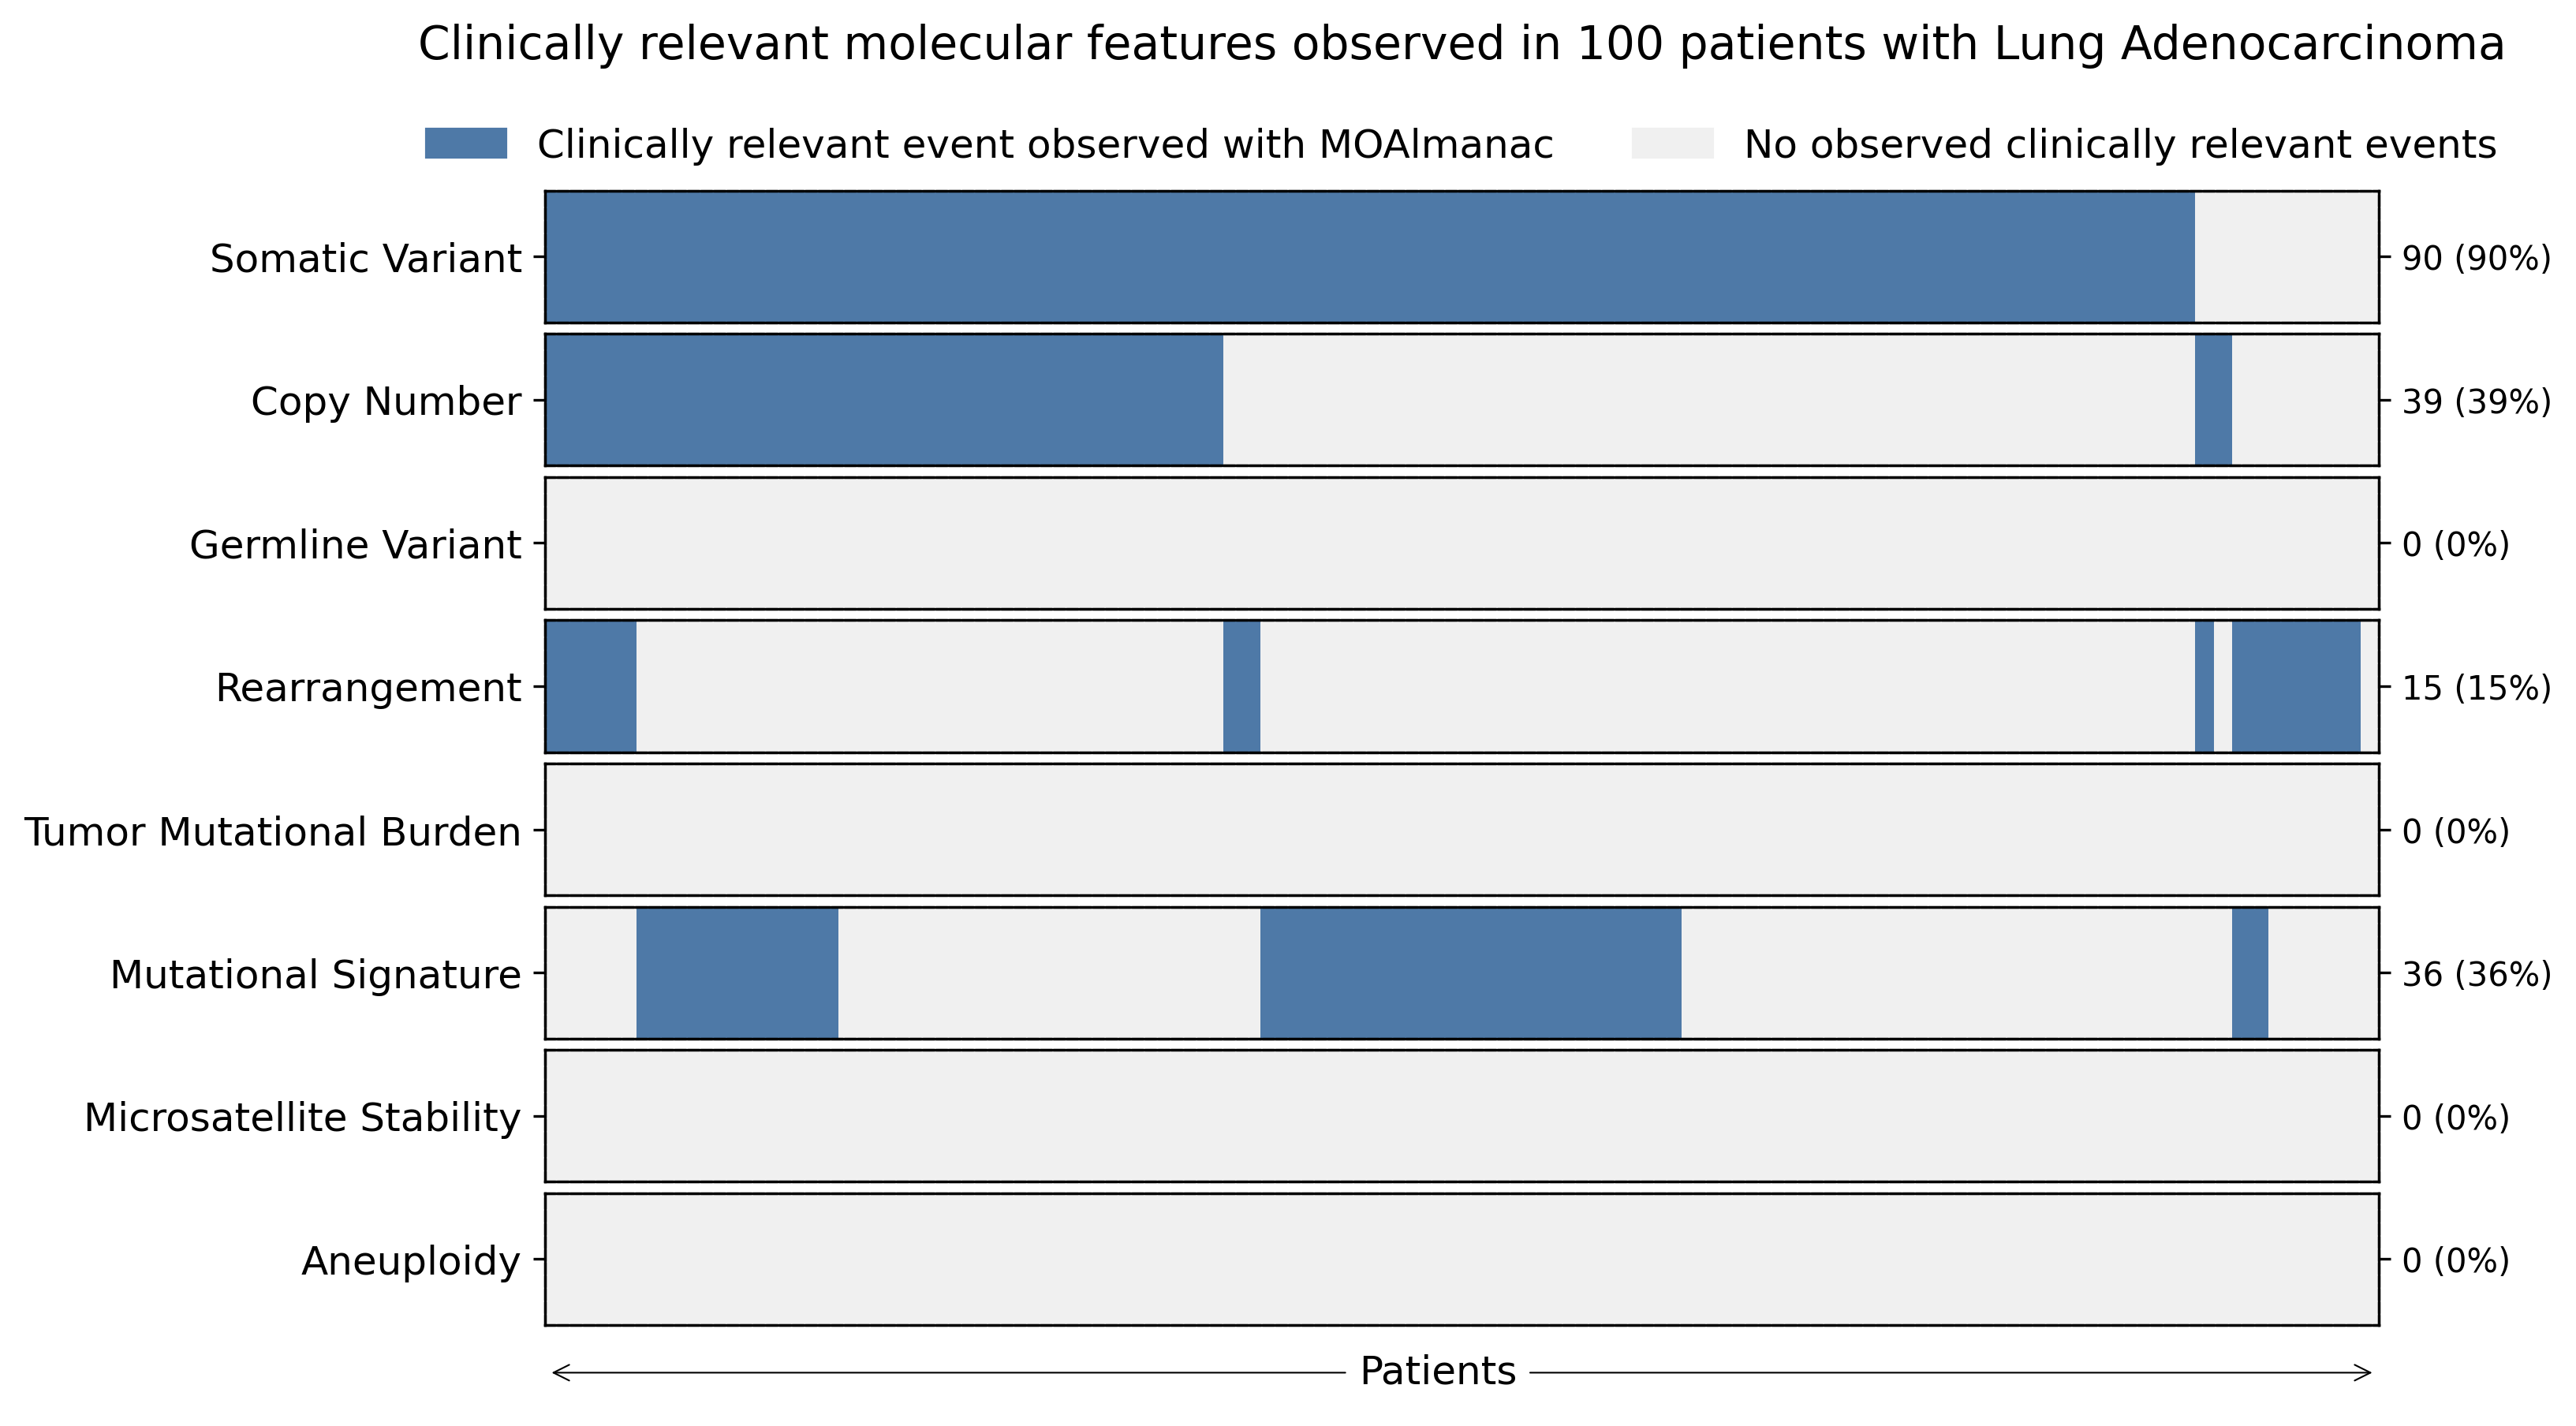

In [50]:
fig = plt.figure(figsize=(10, 7.5), dpi=300)

height_ratios = [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1]
gs = gridspec.GridSpec(11, 1, hspace=0.1, wspace=0, height_ratios=height_ratios)

colors_bars = [tableau10['white'], tableau10['blue']]
cmap = colors.ListedColormap(colors_bars)
bounds = [0, 1, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_string = f'Clinically relevant molecular features observed in {len(patient_ids)} patients with {DISEASE}'
plot_title(
    ax=plt.subplot(gs[0, :]),
    string=title_string,
    fontsize=TITLE_FONT_SIZE
)

plot_legend(
    ax=plt.subplot(gs[1, :]),
    labels=['Clinically relevant event observed with MOAlmanac','No observed clinically relevant events'],
    label_colors=[tableau10['blue'], tableau10['white']],
    fontsize=LEGEND_FONT_SIZE,
    n_columns=2
)

right_labels = df.apply(lambda x: f"{int(x.sum())} ({int(round(x.sum() * 100 / len(patient_ids), 0))}%)", axis=1)

plot_bars(
    dataframe=df, 
    grid=gs, 
    cmap=cmap, 
    norm=norm, 
    left_labels_shown=True, 
    right_labels=right_labels,
    row_plus=2, 
    fontsize=AXIS_LABEL_FONT_SIZE,
)

plot_patient_label(
    ax=plt.subplot(gs[10, :]),
    size=AXIS_LABEL_FONT_SIZE
)

if SAVE_FIGURES:
    for filetype in FILE_TYPES:
        outname = f"{SAVE_PATH}/{filename}.{filetype}"
        plt.savefig(outname, format=filetype, bbox_inches='tight', dpi=300)

plt.show()

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="associations-by-evidence-for-therapeutic-sensitivity"></a>
## Associations by evidence for therapeutic sensitivity
This figure will be a 6 x 2 grid with the most common genomic alterations on the left and therapies on the right, both in rows ordered by evidence.

In [51]:
filename = "associations-by-evidence.therapeutic-sensitivity"

In [52]:
VIEW = 5

df = actionable
df['feature_display'] = (
    df['feature_display']
    .str.replace(' \(Missense\)', '', regex=True)
    .str.replace(' \(Deletion\)', '', regex=True)
    .str.replace(' \(Splice Site\)', ' splice site', regex=True)
    .str.replace(' \(Nonsense\)', '', regex=True)
    .str.replace(' \(Frameshift\)', '', regex=True)
    .str.replace(' p.splice', '', regex=True)
    .str.replace(' Fusion', '', regex=True)
    .str.replace(' \(version 2\)', '', regex=True)
)

idx_signature = df['feature_type'].eq('Mutational Signature')
df.loc[idx_signature, 'feature_display'] = (
    df
    .loc[idx_signature, 'feature_display']
    .str.split('\(')
    .apply(lambda x: ' '.join(x[:-1]))
)

alterations_by_evidence = {}
therapies_by_evidence = {}

for evidence in evidence_levels:
    idx = df[df['sensitive_predictive_implication'].eq(evidence)].index
    alterations = df.loc[idx, 'feature_display'].value_counts()
    therapies = df.loc[idx, 'sensitive_therapy_name'].value_counts()
    alterations_by_evidence[evidence] = alterations
    therapies_by_evidence[evidence] = therapies

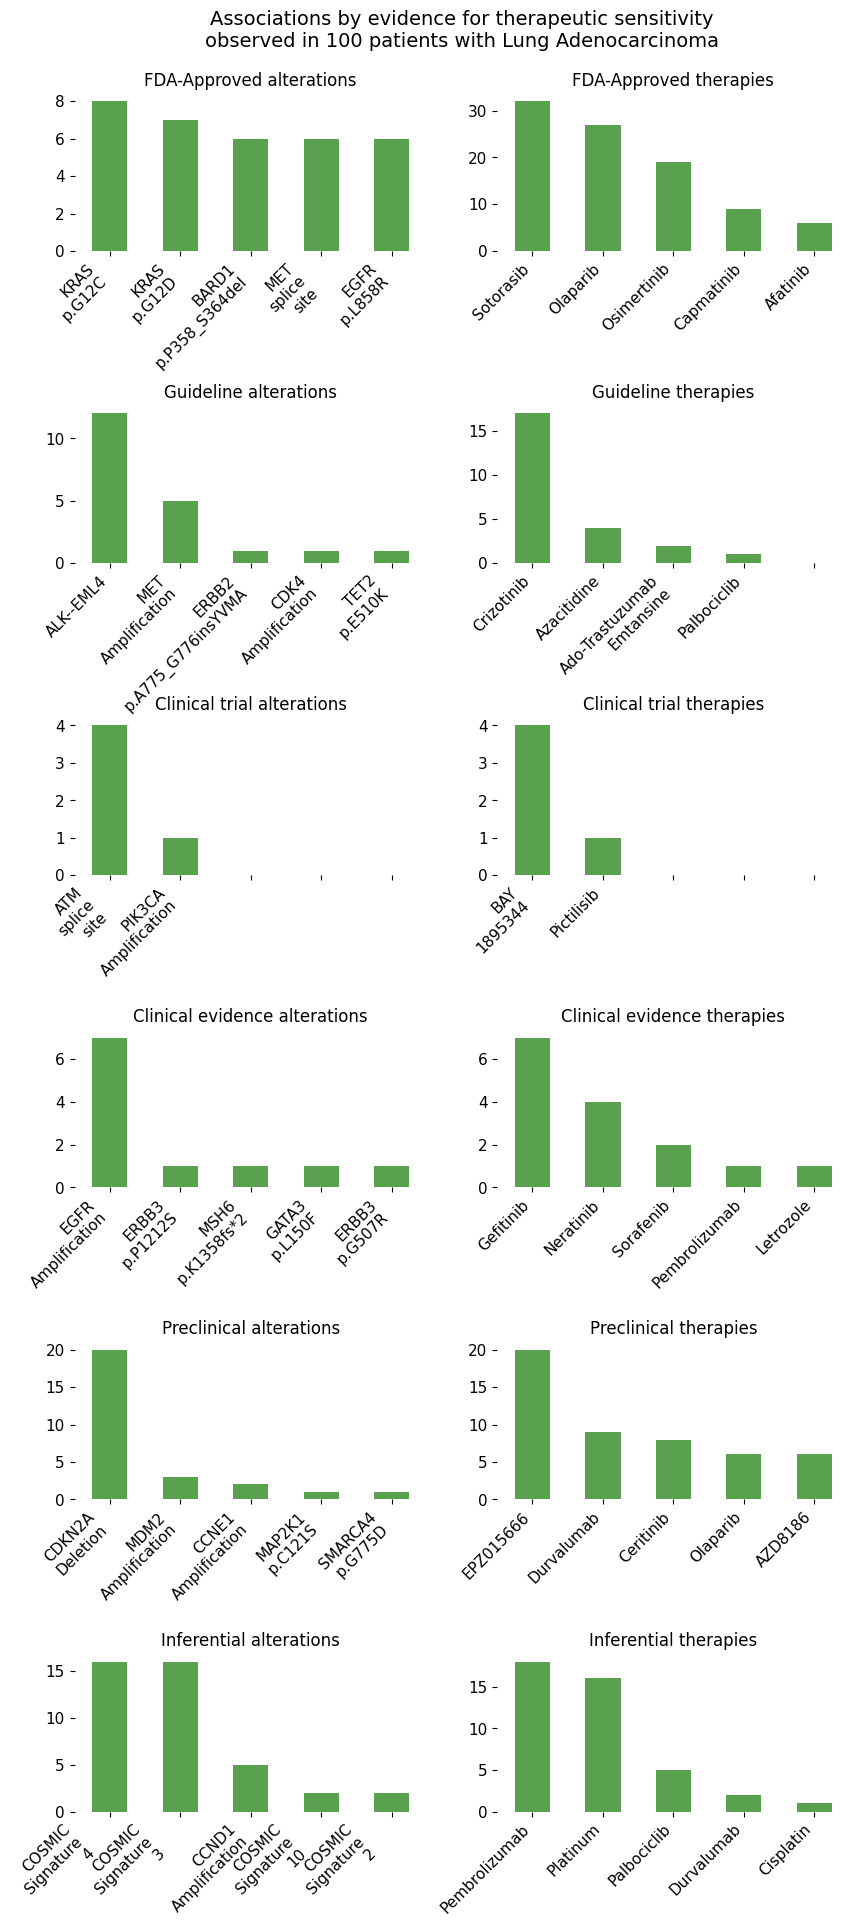

In [53]:
fig = plt.figure(constrained_layout=True, figsize=(10, 25))

height_ratios = [1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
spec = gridspec.GridSpec(ncols=2, nrows=13, figure=fig, height_ratios=height_ratios)

title_string = f"Associations by evidence for therapeutic sensitivity\nobserved in {len(patient_ids)} patients with {DISEASE}"
plot_title(
    ax=plt.subplot(gs[0, :]),
    string=title_string,
    fontsize=TITLE_FONT_SIZE
)

ax00 = fig.add_subplot(spec[1,0])
ax10 = fig.add_subplot(spec[3,0])
ax20 = fig.add_subplot(spec[5,0])
ax30 = fig.add_subplot(spec[7,0])
ax40 = fig.add_subplot(spec[9,0])
ax50 = fig.add_subplot(spec[11,0])

ax01 = fig.add_subplot(spec[1,1])
ax11 = fig.add_subplot(spec[3,1])
ax21 = fig.add_subplot(spec[5,1])
ax31 = fig.add_subplot(spec[7,1])
ax41 = fig.add_subplot(spec[9,1])
ax51 = fig.add_subplot(spec[11,1])
    
for evidence, ax_left, ax_right in [
        ('FDA-Approved', ax00, ax01),
        ('Guideline', ax10, ax11),
        ('Clinical trial', ax20, ax21),
        ('Clinical evidence', ax30, ax31),
        ('Preclinical', ax40, ax41),
        ('Inferential', ax50, ax51)
]:
    plot_bar_chart(
        data=alterations_by_evidence[evidence],
        display_count=VIEW,
        ax=ax_left,
        figure=fig, 
        color=tableau10['green'],
        axis_fontsize=AXIS_TICK_FONT_SIZE,
        title_string=f"{evidence} alterations",
        title_fontsize=AXIS_LABEL_FONT_SIZE
    )
    
    plot_bar_chart(
        data=therapies_by_evidence[evidence],
        display_count=VIEW,
        ax=ax_right,
        figure=fig, 
        color=tableau10['green'],
        axis_fontsize=AXIS_TICK_FONT_SIZE,
        title_string=f"{evidence} therapies",
        title_fontsize=AXIS_LABEL_FONT_SIZE
    )
    
if SAVE_FIGURES:
    for filetype in FILE_TYPES:
        outname = f"{SAVE_PATH}/{filename}.{filetype}"
        plt.savefig(outname, format=filetype, bbox_inches='tight', dpi=300)
        
plt.show()

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="associations-by-evidence-for-therapeutic-resistance"></a>
## Associations by evidence for therapeutic resistance
This figure will be a 6 x 2 grid with the most common genomic alterations on the left and therapies on the right, both in rows ordered by evidence.

In [54]:
filename = "associations-by-evidence.therapeutic-resistance"

In [55]:
VIEW = 5

df = actionable
df['feature_display'] = (
    df['feature_display']
    .str.replace(' \(Missense\)', '', regex=True)
    .str.replace(' \(Deletion\)', '', regex=True)
    .str.replace(' \(Splice Site\)', ' splice site', regex=True)
    .str.replace(' \(Nonsense\)', '', regex=True)
    .str.replace(' \(Frameshift\)', '', regex=True)
    .str.replace(' p.splice', '', regex=True)
    .str.replace(' Fusion', '', regex=True)
    .str.replace(' \(version 2\)', '', regex=True)
)

idx_signature = df['feature_type'].eq('Mutational Signature')
df.loc[idx_signature, 'feature_display'] = (
    df
    .loc[idx_signature, 'feature_display']
    .str.split('\(')
    .apply(lambda x: ' '.join(x[:-1]))
)

alterations_by_evidence = {}
therapies_by_evidence = {}

for evidence in evidence_levels:
    idx = df[df['resistance_predictive_implication'].eq(evidence)].index
    alterations = df.loc[idx, 'feature_display'].value_counts()
    therapies = df.loc[idx, 'resistance_therapy_name'].value_counts()
    alterations_by_evidence[evidence] = alterations
    therapies_by_evidence[evidence] = therapies

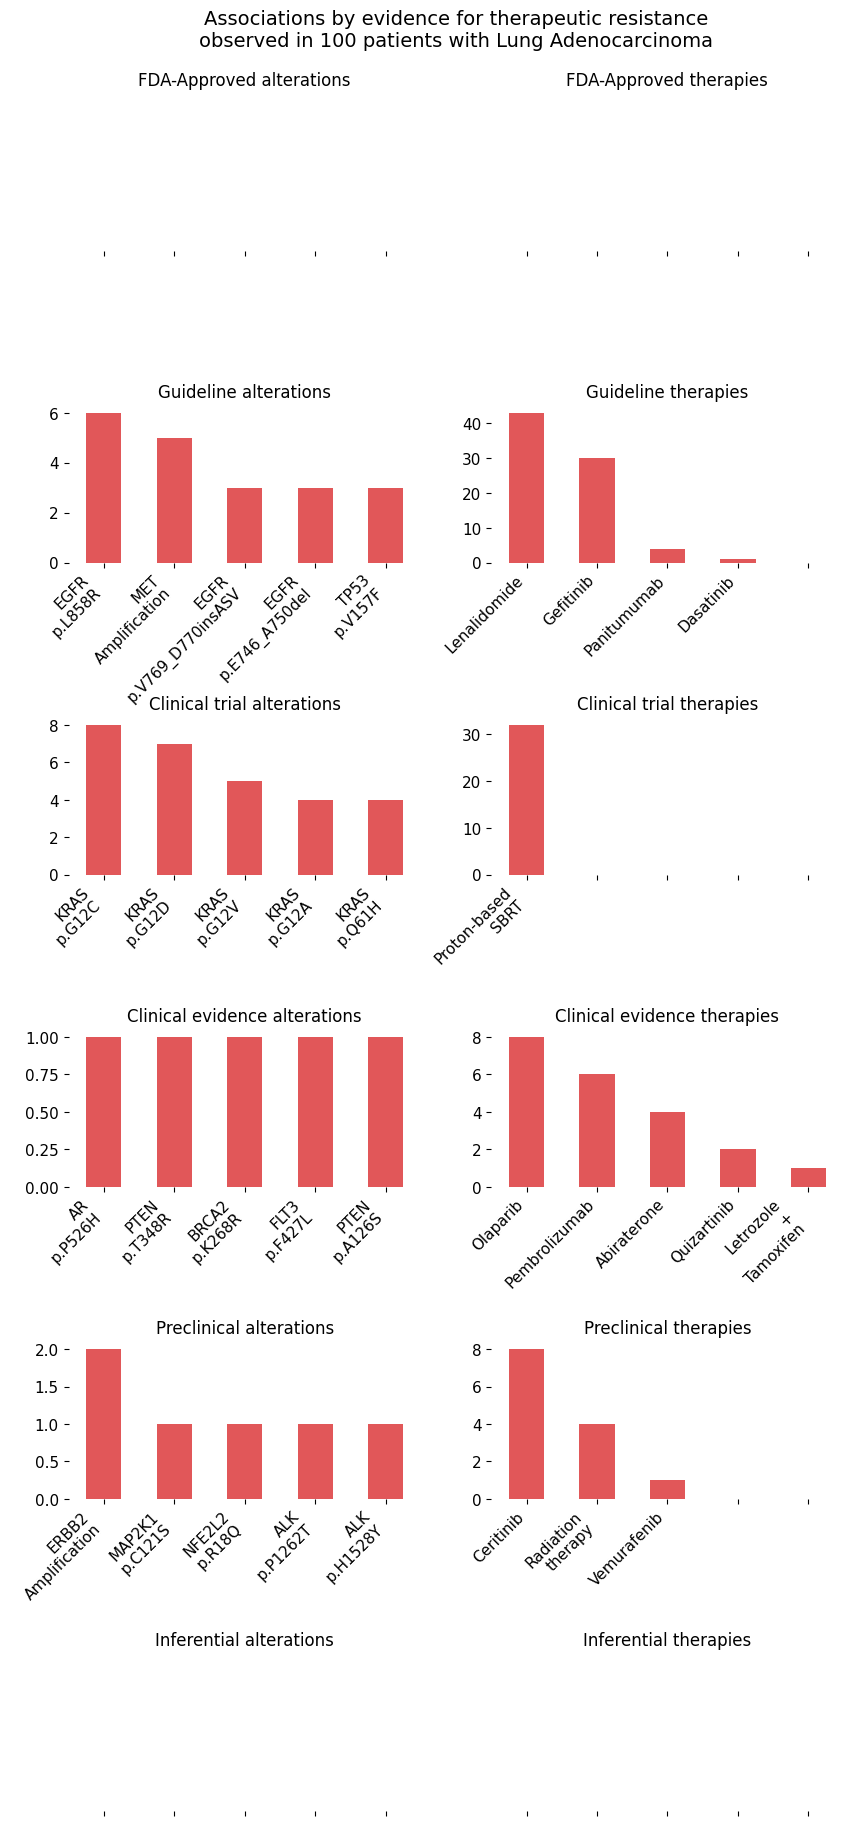

In [56]:
fig = plt.figure(constrained_layout=True, figsize=(10, 25))

height_ratios = [1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
spec = gridspec.GridSpec(ncols=2, nrows=13, figure=fig, height_ratios=height_ratios)

title_string = f"Associations by evidence for therapeutic resistance\nobserved in {len(patient_ids)} patients with {DISEASE}"
plot_title(
    ax=plt.subplot(gs[0, :]),
    string=title_string,
    fontsize=TITLE_FONT_SIZE
)

ax00 = fig.add_subplot(spec[1,0])
ax10 = fig.add_subplot(spec[3,0])
ax20 = fig.add_subplot(spec[5,0])
ax30 = fig.add_subplot(spec[7,0])
ax40 = fig.add_subplot(spec[9,0])
ax50 = fig.add_subplot(spec[11,0])

ax01 = fig.add_subplot(spec[1,1])
ax11 = fig.add_subplot(spec[3,1])
ax21 = fig.add_subplot(spec[5,1])
ax31 = fig.add_subplot(spec[7,1])
ax41 = fig.add_subplot(spec[9,1])
ax51 = fig.add_subplot(spec[11,1])
    
for evidence, ax_left, ax_right in [
        ('FDA-Approved', ax00, ax01),
        ('Guideline', ax10, ax11),
        ('Clinical trial', ax20, ax21),
        ('Clinical evidence', ax30, ax31),
        ('Preclinical', ax40, ax41),
        ('Inferential', ax50, ax51)
]:
    plot_bar_chart(
        data=alterations_by_evidence[evidence],
        display_count=VIEW,
        ax=ax_left,
        figure=fig, 
        color=tableau10['red'],
        axis_fontsize=AXIS_TICK_FONT_SIZE,
        title_string=f"{evidence} alterations",
        title_fontsize=AXIS_LABEL_FONT_SIZE
    )
    
    plot_bar_chart(
        data=therapies_by_evidence[evidence],
        display_count=VIEW,
        ax=ax_right,
        figure=fig, 
        color=tableau10['red'],
        axis_fontsize=AXIS_TICK_FONT_SIZE,
        title_string=f"{evidence} therapies",
        title_fontsize=AXIS_LABEL_FONT_SIZE
    )
    
if SAVE_FIGURES:
    for filetype in FILE_TYPES:
        outname = f"{SAVE_PATH}/{filename}.{filetype}"
        plt.savefig(outname, format=filetype, bbox_inches='tight', dpi=300)
        
plt.show()

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="associations-by-evidence-for-disease-prognosis"></a>
## Associations by evidence for disease prognosis
This figure will be a 6 x 2 grid with the most common genomic alterations on the left and right, for favorable vs unfavorable disease prognosis

In [57]:
filename = "associations-by-evidence.prognosis"

In [58]:
VIEW = 5

df = actionable
df['feature_display'] = (
    df['feature_display']
    .str.replace(' \(Missense\)', '', regex=True)
    .str.replace(' \(Deletion\)', '', regex=True)
    .str.replace(' \(Splice Site\)', ' splice site', regex=True)
    .str.replace(' \(Nonsense\)', '', regex=True)
    .str.replace(' \(Frameshift\)', '', regex=True)
    .str.replace(' p.splice', '', regex=True)
    .str.replace(' Fusion', '', regex=True)
    .str.replace(' \(version 2\)', '', regex=True)
)

idx_signature = df['feature_type'].eq('Mutational Signature')
df.loc[idx_signature, 'feature_display'] = (
    df
    .loc[idx_signature, 'feature_display']
    .str.split('\(')
    .apply(lambda x: ' '.join(x[:-1]))
)

favorable_by_evidence = {}
unfavorable_by_evidence = {}

for evidence in evidence_levels:
    idx_evidence = df['prognostic_predictive_implication'].eq(evidence)
    favorable = df[idx_evidence & df['favorable_prognosis'].eq(1)]
    unfavorable = df[idx_evidence & df['favorable_prognosis'].eq(0)]
    
    favorable_by_evidence[evidence] = favorable['feature_display'].value_counts()
    unfavorable_by_evidence[evidence] = unfavorable['feature_display'].value_counts()

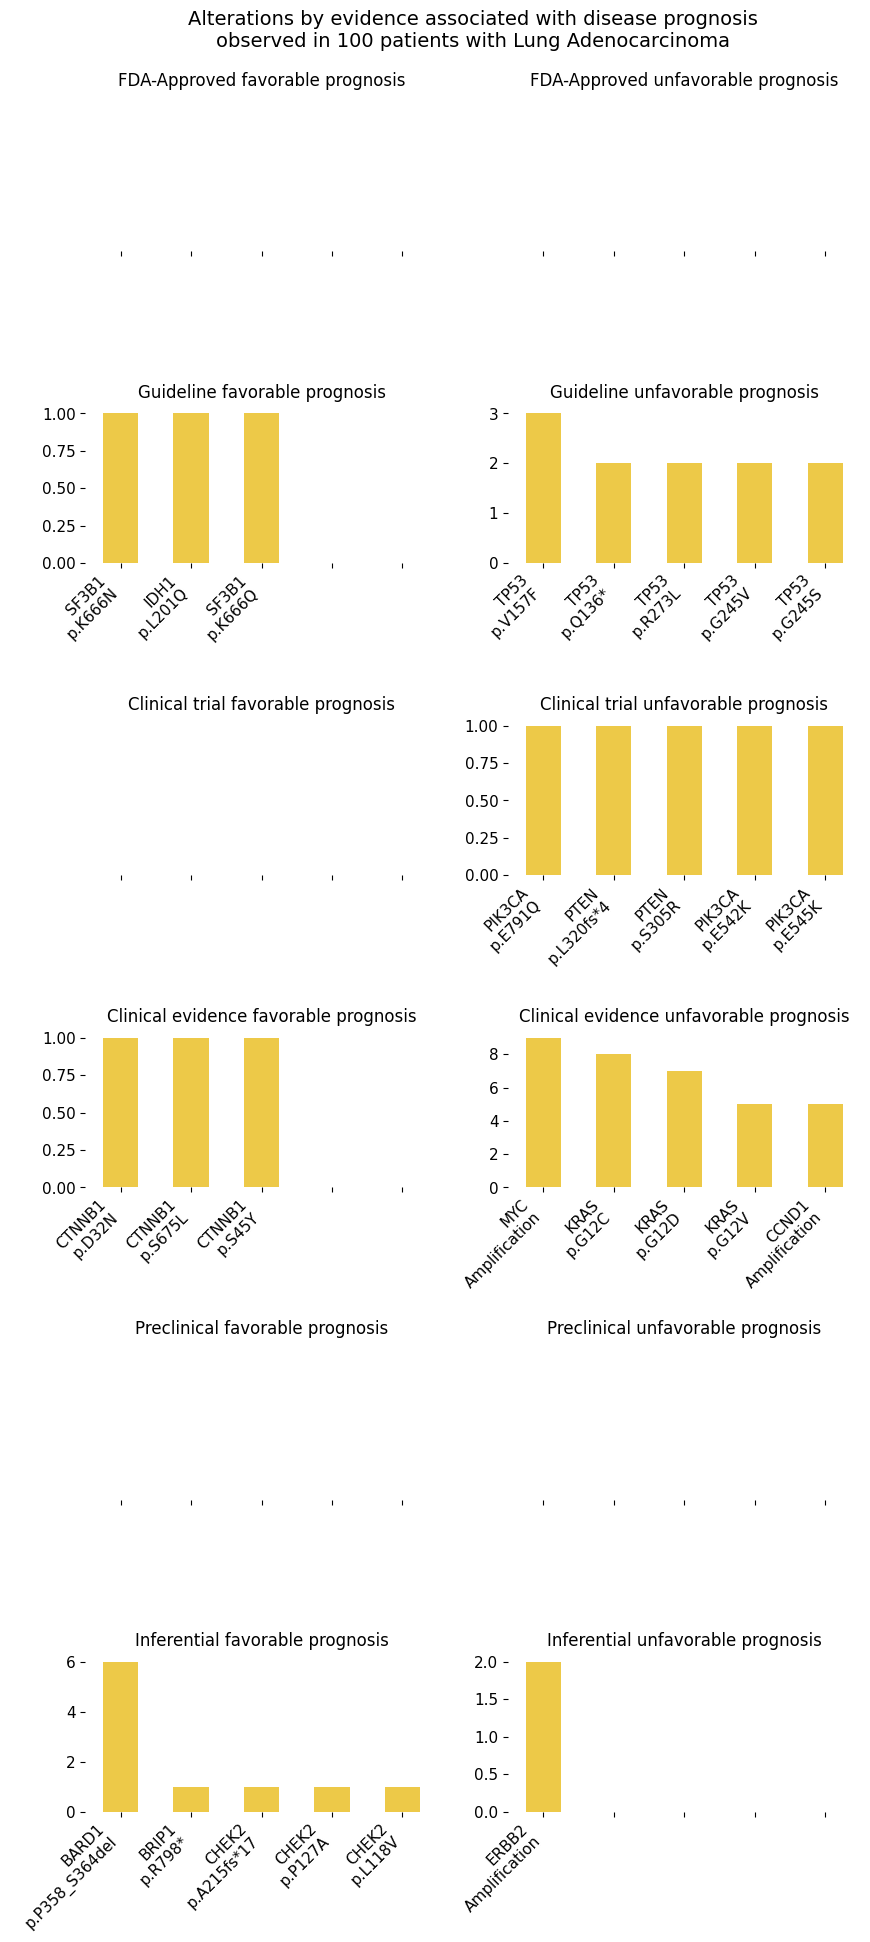

In [59]:
fig = plt.figure(constrained_layout=True, figsize=(10, 25))

height_ratios = [1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
spec = gridspec.GridSpec(ncols=2, nrows=13, figure=fig, height_ratios=height_ratios)

title_string = f"Alterations by evidence associated with disease prognosis\nobserved in {len(patient_ids)} patients with {DISEASE}"
plot_title(
    ax=plt.subplot(gs[0, :]),
    string=title_string,
    fontsize=TITLE_FONT_SIZE
)

ax00 = fig.add_subplot(spec[1,0])
ax10 = fig.add_subplot(spec[3,0])
ax20 = fig.add_subplot(spec[5,0])
ax30 = fig.add_subplot(spec[7,0])
ax40 = fig.add_subplot(spec[9,0])
ax50 = fig.add_subplot(spec[11,0])

ax01 = fig.add_subplot(spec[1,1])
ax11 = fig.add_subplot(spec[3,1])
ax21 = fig.add_subplot(spec[5,1])
ax31 = fig.add_subplot(spec[7,1])
ax41 = fig.add_subplot(spec[9,1])
ax51 = fig.add_subplot(spec[11,1])
    
for evidence, ax_left, ax_right in [
        ('FDA-Approved', ax00, ax01),
        ('Guideline', ax10, ax11),
        ('Clinical trial', ax20, ax21),
        ('Clinical evidence', ax30, ax31),
        ('Preclinical', ax40, ax41),
        ('Inferential', ax50, ax51)
]:
    plot_bar_chart(
        data=favorable_by_evidence[evidence],
        display_count=VIEW,
        ax=ax_left,
        figure=fig, 
        color=tableau10['yellow'],
        axis_fontsize=AXIS_TICK_FONT_SIZE,
        title_string=f"{evidence} favorable prognosis",
        title_fontsize=AXIS_LABEL_FONT_SIZE
    )
    
    plot_bar_chart(
        data=unfavorable_by_evidence[evidence],
        display_count=VIEW,
        ax=ax_right,
        figure=fig, 
        color=tableau10['yellow'],
        axis_fontsize=AXIS_TICK_FONT_SIZE,
        title_string=f"{evidence} unfavorable prognosis",
        title_fontsize=AXIS_LABEL_FONT_SIZE
    )
    
if SAVE_FIGURES:
    for filetype in FILE_TYPES:
        outname = f"{SAVE_PATH}/{filename}.{filetype}"
        plt.savefig(outname, format=filetype, bbox_inches='tight', dpi=300)
        
plt.show()

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="fraction-of-patients-by-evidence-sensitivity"></a>
## Fraction of patients harboring at least one alteration associated with therapeutic sensitivity, by evidence
Here, we create a horizontal bar chart showing the additional patients that obtain an association with therapeutic sensitivity as evidence considered expands. 

In [60]:
filename = "patient-cumulative-counts-by-evidence.sensitivity"

In [61]:
association_type = "sensitive_predictive_implication"

df = (
    actionable
    .loc[
        actionable[association_type].notnull(),
        [association_type, 'patient_id']
    ]
    .drop_duplicates()
)

evidence_map = {
    'FDA-Approved': 6,
    'Guideline': 5,
    'Clinical trial': 4,
    'Clinical evidence': 3,
    'Preclinical': 2,
    'Inferential': 1,
    'None': 0
}

color = 'green'
color_map = {
    'FDA-Approved': google[f'dark {color} 3'],
    'Guideline': google[f'dark {color} 2'],
    'Clinical trial': google[f'dark {color} 1'],
    'Clinical evidence': google[f'light {color} 3'],
    'Preclinical': google[f'light {color} 2'],
    'Inferential': google[f'light {color} 1'],
    'None': google['light grey 1']
}

df['evidence_map'] = df[association_type].replace(evidence_map)

results = []
cumulative_evidence = []
for evidence in evidence_levels:
    cumulative_evidence.append(evidence)
    counts = (
        df
        .loc[df[association_type].isin(cumulative_evidence)]
        .loc[:, 'patient_id']
        .drop_duplicates()
        .shape[0]
    )
    percentage = round(counts * 100 / len(patient_ids), 2)
    results.append((evidence, counts, percentage))

results = pd.DataFrame(results, columns=['evidence', 'patient counts', 'patient percentage'])

max_percentage = results['patient percentage'].iloc[-1]
none_dictionary = {'evidence': 'None', 'patient counts': len(patient_ids), 'patient percentage': 100}
none_dataframe = pd.Series(none_dictionary).to_frame().T

results = pd.concat([results, none_dataframe], ignore_index=True)
results

,evidence,patient counts,patient percentage
0,FDA-Approved,81,81.0
1,Guideline,86,86.0
2,Clinical trial,86,86.0
3,Clinical evidence,88,88.0
4,Preclinical,96,96.0
5,Inferential,97,97.0
6,None,100,100


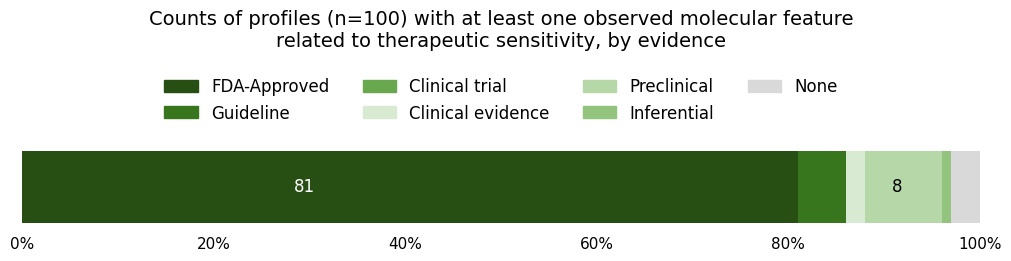

In [62]:
fig = plt.figure(constrained_layout=True, figsize=(10, 2.5))

height_ratios = [1, 3, 3]
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, height_ratios=height_ratios)

title_string = f"Counts of profiles (n={len(patient_ids)}) with at least one observed molecular feature\nrelated to therapeutic sensitivity, by evidence"
plot_title(
    ax=plt.subplot(spec[0, 0]),
    string=title_string,
    fontsize=TITLE_FONT_SIZE
)

plot_legend(
    ax=plt.subplot(spec[1, 0]),
    labels=results['evidence'].tolist(),
    label_colors=list(color_map.values()),
    fontsize=LEGEND_FONT_SIZE,
    n_columns=4
)

plot_horizontal_bar_chart(
    data=results,
    ax=plt.subplot(spec[2, 0]),
    color_map=color_map, 
    axis_tick_font_size=AXIS_TICK_FONT_SIZE, 
    axis_label_font_size=AXIS_LABEL_FONT_SIZE
)

if SAVE_FIGURES:
    for filetype in FILE_TYPES:
        outname = f"{SAVE_PATH}/{filename}.{filetype}"
        plt.savefig(outname, format=filetype, bbox_inches='tight', dpi=300)
        
plt.show()

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="fraction-of-patients-by-evidence-resistance"></a>
## Fraction of patients harboring at least one alteration associated with therapeutic resistance, by evidence
Here, we create a horizontal bar chart showing the additional patients that obtain an association with therapeutic resistance as evidence considered expands. 

In [63]:
filename = "patient-cumulative-counts-by-evidence.resistance"

In [64]:
association_type = "resistance_predictive_implication"

df = (
    actionable
    .loc[
        actionable[association_type].notnull(),
        [association_type, 'patient_id']
    ]
    .drop_duplicates()
)

evidence_map = {
    'FDA-Approved': 6,
    'Guideline': 5,
    'Clinical trial': 4,
    'Clinical evidence': 3,
    'Preclinical': 2,
    'Inferential': 1,
    'None': 0
}

color = 'red'
color_map = {
    'FDA-Approved': google[f'dark {color} 3'],
    'Guideline': google[f'dark {color} 2'],
    'Clinical trial': google[f'dark {color} 1'],
    'Clinical evidence': google[f'light {color} 3'],
    'Preclinical': google[f'light {color} 2'],
    'Inferential': google[f'light {color} 1'],
    'None': google['light grey 1']
}

df['evidence_map'] = df[association_type].replace(evidence_map)

results = []
cumulative_evidence = []
for evidence in evidence_levels:
    cumulative_evidence.append(evidence)
    counts = (
        df
        .loc[df[association_type].isin(cumulative_evidence)]
        .loc[:, 'patient_id']
        .drop_duplicates()
        .shape[0]
    )
    percentage = round(counts * 100 / len(patient_ids), 2)
    results.append((evidence, counts, percentage))

results = pd.DataFrame(results, columns=['evidence', 'patient counts', 'patient percentage'])

max_percentage = results['patient percentage'].iloc[-1]
none_dictionary = {'evidence': 'None', 'patient counts': len(patient_ids), 'patient percentage': 100}
none_dataframe = pd.Series(none_dictionary).to_frame().T

results = pd.concat([results, none_dataframe], ignore_index=True)
results

,evidence,patient counts,patient percentage
0,FDA-Approved,0,0.0
1,Guideline,51,51.0
2,Clinical trial,71,71.0
3,Clinical evidence,76,76.0
4,Preclinical,77,77.0
5,Inferential,77,77.0
6,None,100,100


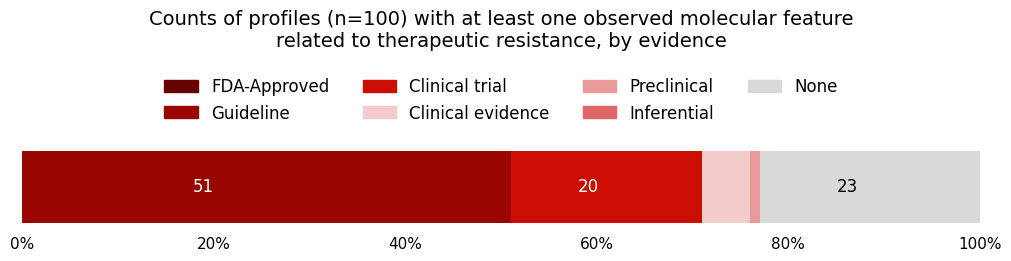

In [65]:
fig = plt.figure(constrained_layout=True, figsize=(10, 2.5))

height_ratios = [1, 3, 3]
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, height_ratios=height_ratios)

title_string = f"Counts of profiles (n={len(patient_ids)}) with at least one observed molecular feature\nrelated to therapeutic resistance, by evidence"
plot_title(
    ax=plt.subplot(spec[0, 0]),
    string=title_string,
    fontsize=TITLE_FONT_SIZE
)

plot_legend(
    ax=plt.subplot(spec[1, 0]),
    labels=results['evidence'].tolist(),
    label_colors=list(color_map.values()),
    fontsize=LEGEND_FONT_SIZE,
    n_columns=4
)

plot_horizontal_bar_chart(
    data=results,
    ax=plt.subplot(spec[2, 0]),
    color_map=color_map, 
    axis_tick_font_size=AXIS_TICK_FONT_SIZE, 
    axis_label_font_size=AXIS_LABEL_FONT_SIZE
)

if SAVE_FIGURES:
    for filetype in FILE_TYPES:
        outname = f"{SAVE_PATH}/{filename}.{filetype}"
        plt.savefig(outname, format=filetype, bbox_inches='tight', dpi=300)
        
plt.show()

[Return to Table of Contents](#table-of-contents)

<a href="anchor" id="fraction-of-patients-by-evidence-prognosis"></a>
## Fraction of patients harboring at least one alteration associated with disease prognosis, by evidence
Here, we create a horizontal bar chart showing the additional patients that obtain an association with disease prognosis as evidence considered expands. 

In [66]:
filename = "patient-cumulative-counts-by-evidence.prognosis"

In [67]:
association_type = "prognostic_predictive_implication"

df = (
    actionable
    .loc[
        actionable[association_type].notnull(),
        [association_type, 'patient_id']
    ]
    .drop_duplicates()
)

evidence_map = {
    'FDA-Approved': 6,
    'Guideline': 5,
    'Clinical trial': 4,
    'Clinical evidence': 3,
    'Preclinical': 2,
    'Inferential': 1,
    'None': 0
}

color = 'yellow'
color_map = {
    'FDA-Approved': google[f'dark {color} 3'],
    'Guideline': google[f'dark {color} 2'],
    'Clinical trial': google[f'dark {color} 1'],
    'Clinical evidence': google[f'light {color} 3'],
    'Preclinical': google[f'light {color} 2'],
    'Inferential': google[f'light {color} 1'],
    'None': google['light grey 1']
}

df['evidence_map'] = df[association_type].replace(evidence_map)

results = []
cumulative_evidence = []
for evidence in evidence_levels:
    cumulative_evidence.append(evidence)
    counts = (
        df
        .loc[df[association_type].isin(cumulative_evidence)]
        .loc[:, 'patient_id']
        .drop_duplicates()
        .shape[0]
    )
    percentage = round(counts * 100 / len(patient_ids), 2)
    results.append((evidence, counts, percentage))

results = pd.DataFrame(results, columns=['evidence', 'patient counts', 'patient percentage'])

max_percentage = results['patient percentage'].iloc[-1]
none_dictionary = {'evidence': 'None', 'patient counts': len(patient_ids), 'patient percentage': 100}
none_dataframe = pd.Series(none_dictionary).to_frame().T

results = pd.concat([results, none_dataframe], ignore_index=True)
results

,evidence,patient counts,patient percentage
0,FDA-Approved,0,0.0
1,Guideline,48,48.0
2,Clinical trial,55,55.0
3,Clinical evidence,78,78.0
4,Preclinical,78,78.0
5,Inferential,80,80.0
6,None,100,100


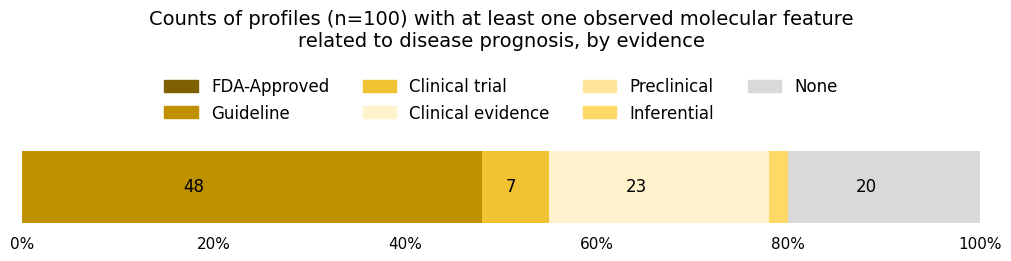

In [68]:
fig = plt.figure(constrained_layout=True, figsize=(10, 2.5))

height_ratios = [1, 3, 3]
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, height_ratios=height_ratios)

title_string = f"Counts of profiles (n={len(patient_ids)}) with at least one observed molecular feature\nrelated to disease prognosis, by evidence"
plot_title(
    ax=plt.subplot(spec[0, 0]),
    string=title_string,
    fontsize=TITLE_FONT_SIZE
)

plot_legend(
    ax=plt.subplot(spec[1, 0]),
    labels=results['evidence'].tolist(),
    label_colors=list(color_map.values()),
    fontsize=LEGEND_FONT_SIZE,
    n_columns=4
)

plot_horizontal_bar_chart(
    data=results,
    ax=plt.subplot(spec[2, 0]),
    color_map=color_map, 
    axis_tick_font_size=AXIS_TICK_FONT_SIZE, 
    axis_label_font_size=AXIS_LABEL_FONT_SIZE,
    change_text_color=False
)

if SAVE_FIGURES:
    for filetype in FILE_TYPES:
        outname = f"{SAVE_PATH}/{filename}.{filetype}"
        plt.savefig(outname, format=filetype, bbox_inches='tight', dpi=300)
        
plt.show()

[Return to Table of Contents](#table-of-contents)